In [187]:
#!L
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import warnings

In [314]:
#!L
from catboost import CatBoostRegressor, monoforest, Pool, cv
from catboost.utils import create_cd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, lasso_path
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
from scipy import stats
from collections import defaultdict
from sklearn.model_selection import KFold

In [189]:
#!L
warnings.filterwarnings('ignore')

In [293]:
#!L
IMAT2009_PATH = os.path.join('resources', 'imat2009')
RANDOM_STATE = 23923
LOGS_PATH = os.path.join('resources', 'logs')

In [328]:
#!L
PICKLE_DUMPS_PATH = os.path.join('resources', 'pickle_dumps')

def save_via_pickle(obj, filepath):
    with open(filepath, 'wb') as output_file:
        pickle.dump(obj, output_file)
        
def load_from_pickle(filepath):
    with open(filepath, 'rb') as input_file:
        return pickle.load(input_file)
    
def get_pickle_dump_path(dump_name):
    return os.path.join(PICKLE_DUMPS_PATH, f'{dump_name}.pkl')

In [331]:
#!L
def update_log(log_name, lines, clear=False):
    log_path = os.path.join(LOGS_PATH, f'{log_name}.log')
    mode = 'w' if (clear or not os.path.exists(log_path)) else 'a'
    with open(log_path, mode) as log_file:
        log_file.write(os.linesep.join(list(map(str, lines))) + os.linesep)

In [191]:
#!L
def load_imat2009_data(subset='train'):
    filename = f'imat2009_{subset}.txt'
    with open(os.path.join(IMAT2009_PATH, filename), 'r') as input_file:
        return list(input_file.readlines())

In [192]:
#!L
def _parse_imat2009_line(line):
    line = line.replace(os.linesep, '')
    chunks = line.split('#')
    line, query_id = chunks[0], int(chunks[1])
    chunks = line.split(' ')
    relevance = float(chunks[0])
    features = [0 for _ in range(245)]
    for chunk in chunks[1:]:
        feature_chunks = chunk.split(':')
        if feature_chunks[0] == '':
            continue
        features[int(feature_chunks[0]) - 1] = float(feature_chunks[1])
    return query_id, features, relevance

In [193]:
#!L
def load_query_id_stats():
    stats = defaultdict(lambda: [])
    for key in ['train', 'test']:
        freqs = defaultdict(lambda: 0)
        for line in tqdm(load_imat2009_data(key)):
            freqs[_parse_imat2009_line(line)[0]] += 1
        for k, v in freqs.items():
            stats['subset'].append(key)
            stats['query id'].append(k)
            stats['frequency'].append(v)
    stats_df = pd.DataFrame(data=dict(stats))
    return stats_df

In [194]:
#!L
def load_lines_for_query_id():
    qid_to_lines = defaultdict(lambda: [])
    for key in ['train', 'test']:
        for i, line in enumerate(tqdm(load_imat2009_data(key))):
            qid_to_lines[(key, _parse_imat2009_line(line)[0])].append(i)
    return dict(qid_to_lines)

In [195]:
#!L
stats = load_query_id_stats()

100%|██████████| 115643/115643 [00:18<00:00, 6260.73it/s]


In [196]:
#!L
stats.head()

,subset,query id,frequency
0,train,3382,7
1,train,11800,13
2,train,21991,13
3,train,19719,4
4,train,11542,5


In [197]:
#!L
train_stats = stats[stats['subset'] == 'train']

In [198]:
#!L
qid_to_lines = load_lines_for_query_id()

100%|██████████| 115643/115643 [00:18<00:00, 6273.07it/s]


In [199]:
#!L
for index, row in train_stats.iterrows():
    q, f1 = row['query id'], row['frequency']
    f2 = len(qid_to_lines[('train', q)])
    print(f'{q}: {f1} vs {f2}')
    break

3382: 7 vs 7


In [200]:
#!L
stats.groupby('frequency').count()

,subset,query id
frequency,,
2,924,924
3,975,975
4,1119,1119
5,1207,1207
6,1383,1383
...,...,...
427,1,1
434,1,1
452,1,1


In [201]:
#!L
def sample_subset(approximate_size, values, sizes, verbose=True):
    n = values.shape[0]
    sampled_values = np.random.choice(n, min(approximate_size, n), replace=False, p=1. * sizes / sizes.sum())
    current_size = 0
    output_values = []
    for new_value in sampled_values:
        current_size += sizes[new_value]
        output_values.append(values[new_value])
        if current_size > approximate_size:
            break
        
    if verbose:
        print(f'Totaly sampled {i} values with total size {current_size}')
    return output_values

In [202]:
#!L
samples_number = 200
target_size = 5000

sampled_quid = [sample_subset(target_size, train_stats['query id'], train_stats['frequency'], verbose=False) for _ in range(samples_number)]

In [205]:
#!L
#pragma readonly parsed_lines
parsed_lines = [_parse_imat2009_line(line) for line in tqdm(load_imat2009_data())]

100%|██████████| 97290/97290 [00:16<00:00, 5734.30it/s]


In [206]:
#!L
#pragma readonly info
def prepare_dataset_for_query_id(query_id):
    return [parsed_lines[i][1] for i in qid_to_lines['train', query_id]], [parsed_lines[i][2] for i in qid_to_lines['train', query_id]]

def prepare_dataset(query_ids):
    info = [prepare_dataset_for_query_id(q) for q in query_ids]
    return np.vstack([i[0] for i in tqdm(info)]), np.concatenate([i[1] for i in tqdm(info)])

In [214]:
#!L
#pragma readonly qr
X, y = prepare_dataset(sampled_quid[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)        

100%|██████████| 176/176 [00:00<00:00, 442564.45it/s]


In [223]:
#!L
reg = CatBoostRegressor(verbose=False)
reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 1001
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'bytes'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [224]:
#!L
monomials = monoforest.to_polynom(reg)

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 50429
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 1001
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'bytes'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [227]:
#!L
print(monomials[0], monomials[0].value, monomials[0].weight)

(0.009645991925768035) * [F13 > 0.02549000084400177][F68 > 0.0007604999700561166][F147 > 0.37647050619125366] [0.009645991925768035] 8.0


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 50429
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 1001
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'bytes'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [234]:
#!L
f, r = prepare_dataset(sampled_quid[0])

100%|██████████| 140/140 [00:00<00:00, 489743.59it/s]
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 97290
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 20267
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [271]:
#!L
def train_catboost_regressor_experimental(regressor_params, X, y, validation_percent=0.2, iterations=5000, verbose=False, max_iter=30, decay=0.99):
    if 'iterations' not in regressor_params:
        regressor_params['iterations'] = iterations
    if 'loss_function' not in regressor_params:
        regressor_params['loss_function'] = 'RMSE'
    loss = regressor_params['loss_function']
    best_model = None
    for depth in range(1, 5):
        if verbose:
            print(f'Depth: {depth}')
        X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=RANDOM_STATE, test_size=validation_percent)
        regressor_params['depth'] = depth
        reg = CatBoostRegressor(**regressor_params)
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
        lr = reg.learning_rate_
        prev_score = reg.best_score_['validation'][loss]
        while True:
            lr *= decay
            regressor_params['learning_rate'] = lr
            new_reg = CatBoostRegressor(**regressor_params)
            new_reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
            score = new_reg.best_score_['validation'][loss]
            if verbose:
                print(f'tree count: {new_reg.tree_count_} (best iter: {new_reg.best_iteration_}), best score: {score}, lr {lr}: ', end='')
            if new_reg.tree_count_ < regressor_params['iterations']:
                if verbose:
                    print('ovefitting detected')
                prev_score = score
                reg = new_reg
            elif score < prev_score:
                if verbose:
                    print('score impoved')
                reg = new_reg
            else:
                if verbose:
                    print('exit')
                break
        if best_model is None or best_model.best_score_['validation'][loss] > reg.best_score_['validation'][loss]:
            best_model = reg
    return best_model

In [298]:
#!L
default_params = { 'boosting_type': 'Plain',
                   'bootstrap_type': 'No',
                   'score_function': 'L2',
                   'leaf_estimation_method': None }

In [272]:
#!L
train_catboost_regressor_experimental(default_params, f, r, verbose=True)

Depth: 1
tree count: 4987 (best iter: 4986), best score: 0.4802156707626642, lr 0.021750300116837023: ovefitting detected
tree count: 5000 (best iter: 4999), best score: 0.4804236212511713, lr 0.02153279711566865: exit
Depth: 2
tree count: 4871 (best iter: 4870), best score: 0.4653679158903657, lr 0.021317468360066413: ovefitting detected
tree count: 4664 (best iter: 4663), best score: 0.4669539895569847, lr 0.021104293676465748: ovefitting detected
tree count: 4607 (best iter: 4606), best score: 0.46708617272642755, lr 0.02089325073970109: ovefitting detected
tree count: 4566 (best iter: 4565), best score: 0.46710694636113664, lr 0.02068431823230408: ovefitting detected
tree count: 4377 (best iter: 4376), best score: 0.4661994646647033, lr 0.02047747504998104: ovefitting detected
tree count: 4961 (best iter: 4960), best score: 0.4662108137065175, lr 0.02027270029948123: ovefitting detected
tree count: 4873 (best iter: 4872), best score: 0.4671881476956588, lr 0.020069973296486417: ove

KeyboardInterrupt: 

In [ ]:
# #!L
# def select_catboost_regressor_learning_rate(regressor_params, X, y, depth, verbose=True):
#     if regressor
#     data = Pool(data=X, label=y)
#     regressor_params['depth'] = depth
#     reg = CatBoostRegressor(**regressor_params)
#     reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
#     lr = reg.learning_rate_
#     prev_score = reg.best_score_['validation'][loss]
#     while True:
#         lr *= decay
#         regressor_params['learning_rate'] = lr
#         new_reg = CatBoostRegressor(**regressor_params)
#         new_reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
#         score = new_reg.best_score_['validation'][loss]
#         if verbose:
#             print(f'tree count: {new_reg.tree_count_} (best iter: {new_reg.best_iteration_}), best score: {score}, lr {lr}: ', end='')
#         if new_reg.tree_count_ < regressor_params['iterations']:
#             if verbose:
#                 print('ovefitting detected')
#             prev_score = score
#             reg = new_reg
#         elif score < prev_score:
#             if verbose:
#                 print('score impoved')
#             reg = new_reg
#         else:
#             if verbose:
#                 print('exit')
#             break
#     if best_model is None or best_model.best_score_['validation'][loss] > reg.best_score_['validation'][loss]:
#         best_model = reg
#     return best_model

In [289]:
#!L
def test_number_of_trees_in_catboost_regressor(args, X, y, depth=2, verbose=False, decay=0.9, max_iteratios=100, validation_percent=0.2, initial_lr=None):
    args['iterations'] = 100000
    args['od_type'] = 'Iter'
    args['early_stopping_rounds']  = 20
    args['depth'] = depth
    args['loss_function'] = 'RMSE'
    data = Pool(data=X, label=y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=RANDOM_STATE, test_size=validation_percent)
    number_of_trees = []
    scores = []
    lrs = []
    if initial_lr is None:
        reg = CatBoostRegressor(**args)
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
        current_lr = reg.learning_rate_
    else:
        current_lr = initial_lr
    for _ in range(max_iteratios):
        lrs.append(current_lr)
        args['learning_rate'] = current_lr
        reg = CatBoostRegressor(**args)
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
        number_of_trees.append(reg.best_iteration_ + 1)
        scores.append(reg.best_score_['validation']['RMSE'])
        if verbose:
            print(f'LR: {current_lr}, #trees: {number_of_trees[-1]}, score: {scores[-1]}')
        current_lr *= decay
    
    plt.clf()
    plt.plot(np.log(lrs), number_of_trees)
    plt.xlabel('log(lr)')
    plt.ylabel('#trees')
    plt.show()
    
    plt.clf()
    plt.plot(np.log(lrs), scores)
    plt.xlabel('log(lr)')
    plt.ylabel('RMSE')
    plt.show()
    
    return lrs, scores, number_of_trees

In [282]:
#!L
lrs, scores, number_of_trees = test_number_of_trees_in_catboost_regressor(default_params, f, r, verbose=True, max_iteratios=20, initial_lr=None)

LR: 0.01391394529491663, #trees: 3346, score: 0.4747477710207351
LR: 0.012522550765424967, #trees: 2712, score: 0.4802813058420152
LR: 0.01127029568888247, #trees: 2290, score: 0.4855266902284238
LR: 0.010143266119994223, #trees: 3730, score: 0.47874581344631556
LR: 0.0091289395079948, #trees: 3008, score: 0.4846688110306892
LR: 0.00821604555719532, #trees: 4217, score: 0.4797002690239247
LR: 0.007394441001475787, #trees: 5243, score: 0.47767000370781987
LR: 0.006654996901328209, #trees: 3830, score: 0.48692669568876956
LR: 0.005989497211195388, #trees: 6241, score: 0.47870720070590356
LR: 0.00539054749007585, #trees: 7203, score: 0.4781683474904204
LR: 0.004851492741068265, #trees: 5954, score: 0.484285187262483
LR: 0.004366343466961438, #trees: 6825, score: 0.4832033239800714
LR: 0.003929709120265294, #trees: 7529, score: 0.4838585937929247
LR: 0.003536738208238765, #trees: 8488, score: 0.4833377735162137
LR: 0.0031830643874148886, #trees: 7918, score: 0.4864063450862885
LR: 0.002864

In [284]:
#!L
plt.rcParams['figure.figsize'] = (15, 15)

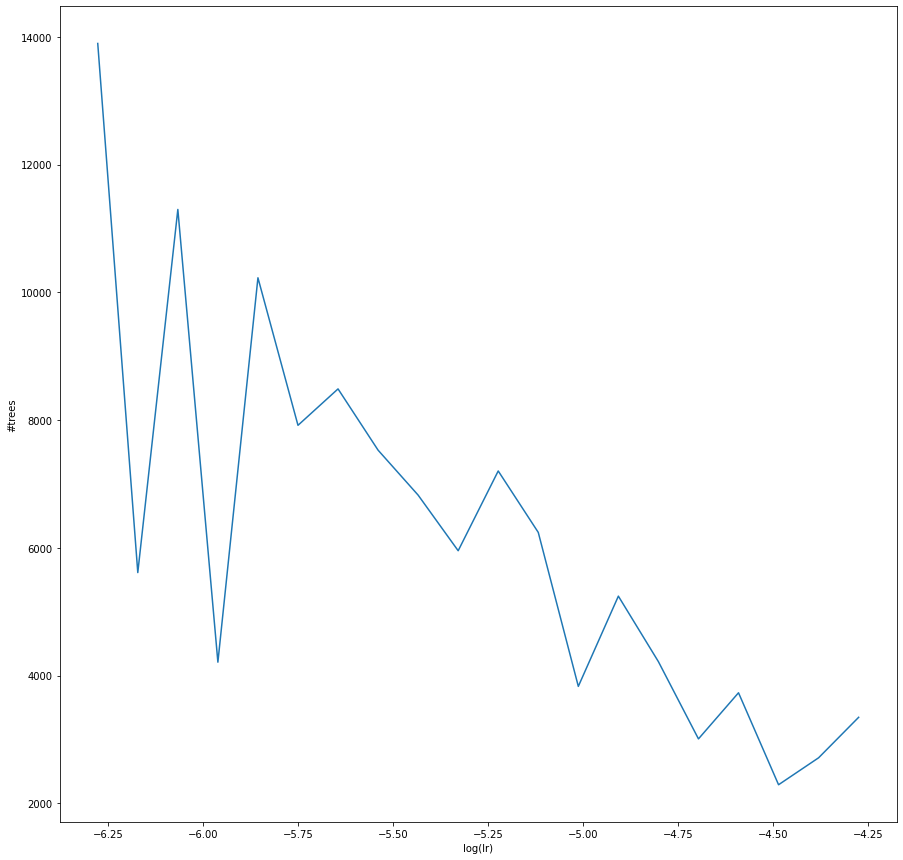

In [285]:
#!L
plt.clf()
plt.plot(np.log(lrs), number_of_trees)
plt.xlabel('log(lr)')
plt.ylabel('#trees')
plt.show()

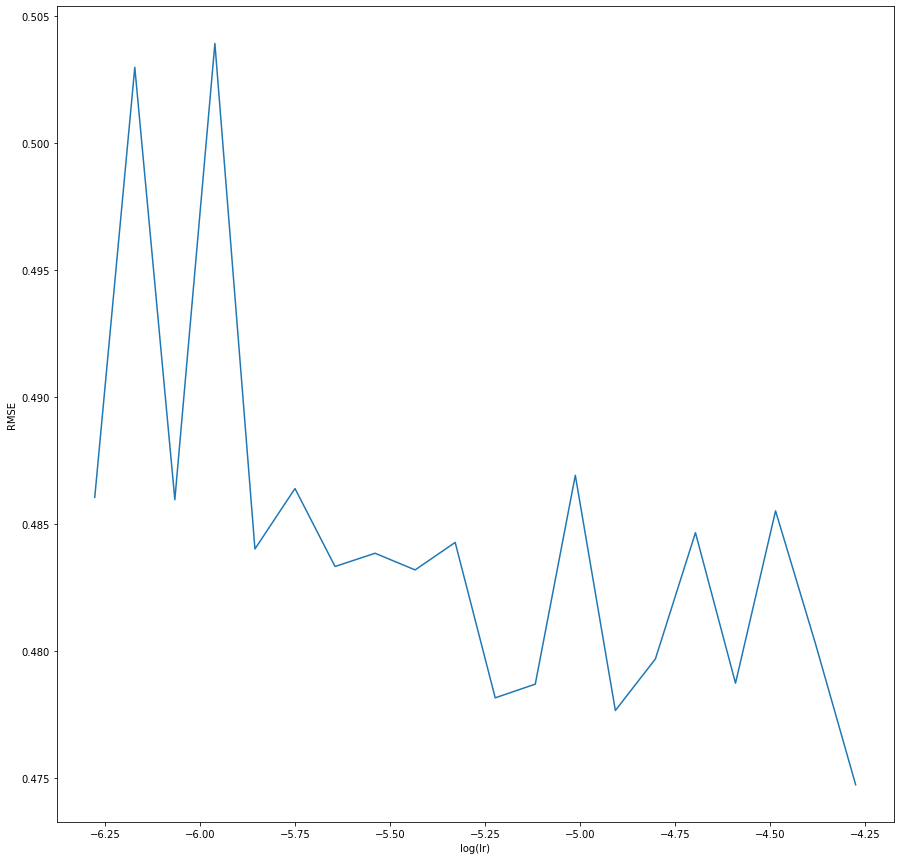

In [286]:
#!L
plt.clf()
plt.plot(np.log(lrs), scores)
plt.xlabel('log(lr)')
plt.ylabel('RMSE')
plt.show()

LR: 0.1, #trees: 432, score: 0.4712950378124713
LR: 0.07500000000000001, #trees: 754, score: 0.4696206517511543
LR: 0.05625000000000001, #trees: 1016, score: 0.4702294617210424
LR: 0.0421875, #trees: 725, score: 0.48335595046848856
LR: 0.031640625000000006, #trees: 1300, score: 0.4761791068471581
LR: 0.023730468750000004, #trees: 1196, score: 0.48374064509347486
LR: 0.0177978515625, #trees: 1676, score: 0.482848951416474
LR: 0.013348388671875001, #trees: 2957, score: 0.4777575310708139
LR: 0.01001129150390625, #trees: 1833, score: 0.493925820978372
LR: 0.007508468627929688, #trees: 5129, score: 0.477972128839445
LR: 0.005631351470947266, #trees: 4221, score: 0.48780354125580616
LR: 0.004223513603210449, #trees: 8771, score: 0.47888893720760667
LR: 0.0031676352024078373, #trees: 8786, score: 0.48469157634921434
LR: 0.002375726401805878, #trees: 11507, score: 0.485138322433852
LR: 0.0017817948013544084, #trees: 4213, score: 0.5107377865007113


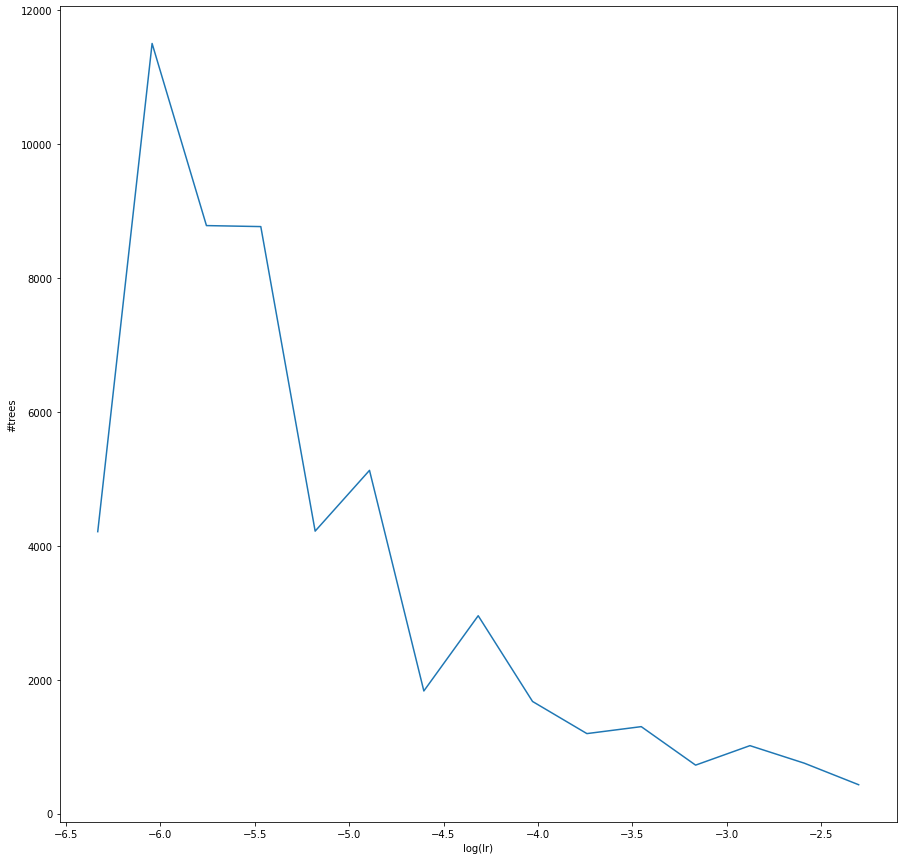

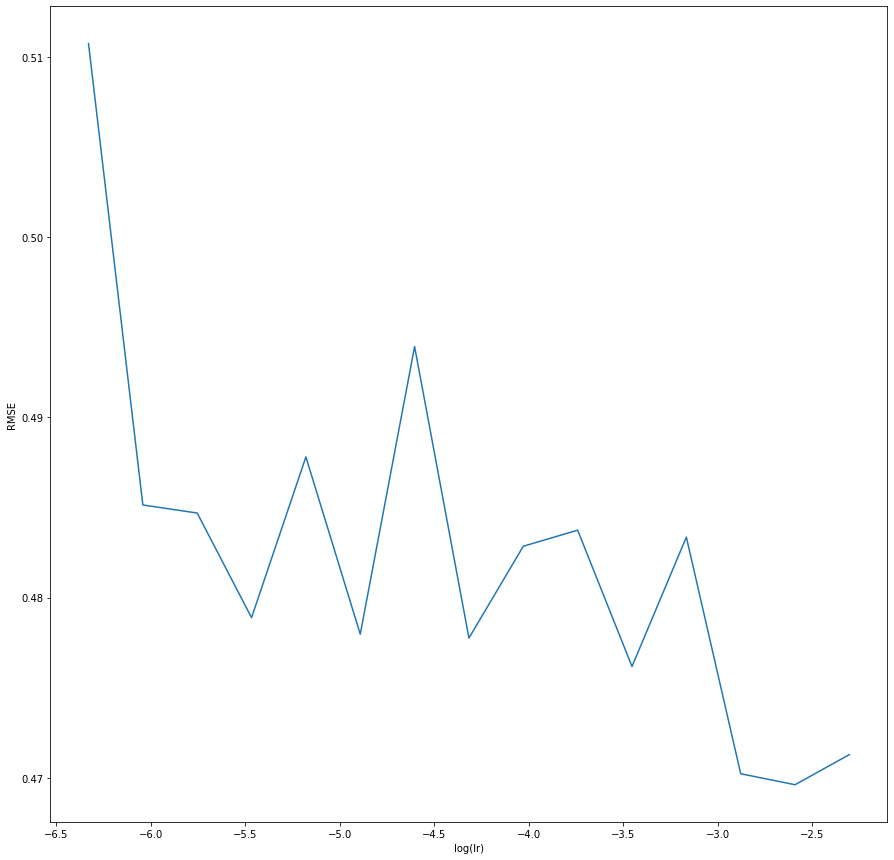

In [291]:
#!L
lrs, scores, number_of_trees = test_number_of_trees_in_catboost_regressor(default_params, f, r, verbose=True, max_iteratios=15, initial_lr=0.1, decay=0.75)

In [296]:
#!L
def chose_learning_rate(regressor_params, X_train, y_train, target_number_of_trees=10000, delta_tolerance=0.1, number_of_batches=5, decay=0.9):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1./number_of_batches, random_state=RANDOM_STATE, shuffle=True)
    regressor_params['iterations'] = target_number_of_trees
    reg = CatBoostRegressor(**regressor_params)
    reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
    lr = reg.learning_rate_
    while True:
        regressor_params['learning_rate'] = lr
        number_of_trees = []
        kf = KFold(n_splits=number_of_batches, shuffle=True, random_state=RANDOM_STATE)
        for train_index, test_index in kf.split(X):
            reg = CatBoostRegressor(**regressor_params)
            reg.fit(X[train_index], y[train_index], eval_set=(X[test_index], y[test_index]), plot=False, use_best_model=True, verbose=False)
            number_of_trees.append(reg.tree_count_)
        all_close_to_target = False
        for number in number_of_trees:
            all_close_to_target = all_close_to_target and np.less(1. * np.abs(reg.tree_count_ - target_number_of_trees) / target_number_of_trees, delta_tolerance)
        if all_close_to_target:
            break
        trees = ', '.join(list(map(str, number_of_trees)))
        print(f'LR: {lr}, #trees: {trees}')
        lr *= decay
    return lr

In [299]:
#!L
chose_learning_rate

{'boosting_type': 'Plain',
 'bootstrap_type': 'No',
 'score_function': 'L2',
 'leaf_estimation_method': None}

In [321]:
#!L
def transform_X_catboost(X, monomials):
    X_out = np.ones((X.shape[0], len(monomials)), dtype=np.bool)
    for i, x in enumerate(X):
        for j, monomial in enumerate(monomials):
            for split in monomial.splits:
                X_out[i, j] = X_out[i, j] and np.less_equal(split.border, x[split.feature_idx])
    return X_out

In [300]:
#!L
default_params = { 'boosting_type': 'Plain',
                   'bootstrap_type': 'No',
                   'score_function': 'L2',
                   'leaf_estimation_method': None }

bootstrap_params = { 'boosting_type' : 'Plain', 
                     'bootstrap_type' : 'Poisson', 
                     'iterations' : 5000,
                     'task_type' : 'GPU',
                     'score_function' : 'L2', 
                     'leaf_estimation_method': None }

all_params = {
    'default' : default_params,
    'bootstrap' : bootstrap_params
}

In [323]:
#!L
def _select_best_lasso_iter(X_train, X_val, y_train, y_val, lambda_arg, max_iter=5000, select_best_iteration=True):
    best_score = None
    best_iter = None
    big_lasso = Lasso(alpha=lambda_arg, max_iter=max_iter).fit(X_train, y_train)
    if not select_best_iteration:
        return mean_squared_error(y_val, big_lasso.predict(X_val), squared=False), max_iter
    lasso = Lasso(alpha=lambda_arg, max_iter=1, warm_start=True)
    for cur_iter in range(1, big_lasso.n_iter_ + 1):
        lasso.fit(X_train, y_train)
        # assert np.allclose(lasso.coef_, Lasso(alpha=lambda_arg, max_iter=cur_iter).fit(X_train, y_train).coef_)
        val_score = mean_squared_error(y_val, lasso.predict(X_val), squared=False)
        if best_score is None or val_score < best_score:
            best_score = val_score
            best_iter = cur_iter
    return best_score, best_iter

def train_best_lasso(X_train, X_val, y_train, y_val, lambda_max=1000, lambda_min=1e-4, decay=0.9,
                     max_iter=5000, iter_step=1, verbose=True, max_lambda_checks=None, without_improvements_filter=None,
                     select_best_iteration=True):
    best_score = None
    best_lambda = None
    best_iter = None
    iter_number = 0
    iter_lim = max_lambda_checks if max_lambda_checks else np.inf
    cur_lambda = lambda_max
    last_imporvment = None
    while np.less(lambda_min, cur_lambda) and iter_number < iter_lim:
        cur_score, cur_iter = _select_best_lasso_iter(X_train, X_val, y_train, y_val, cur_lambda, max_iter, select_best_iteration=select_best_iteration)
        if best_score is None or cur_score < best_score:
            best_score = cur_score
            best_iter = cur_iter
            best_lambda = cur_lambda
            last_imporvment = iter_number
            if verbose:
                print(f'New best score: lambda={cur_lambda}, n_iter={cur_iter}, rmse={cur_score}')
        cur_lambda *= decay
        iter_number += 1
        if verbose and iter_number % 10 == 0:
            print(f'Iter {iter_number}(lambda={cur_lambda}), best: lambda={best_lambda}, n_iter={best_iter}, rmse={best_score}')
        if without_improvements_filter is not None:
            if (last_imporvment is None and iter_number >= without_improvements_filter) or (
                last_imporvment is not None and iter_number - last_imporvment >= without_improvements_filter):
                break
    
    return Lasso(alpha=best_lambda, max_iter = best_iter).fit(X_train, y_train), best_lambda, best_iter

In [324]:
#!L
def get_leaves_distribution_variance(reg, X, y, X_train, y_train):
    X_pool = Pool(data=X, label=y)
    X_train_pool = Pool(data=X_train, label=y_train)
    indices = reg.calc_leaf_indexes(X_pool)
    indices_train = reg.calc_leaf_indexes(X_train_pool)
    counts = []
    counts_train = []
    leaves_count = 0
    for tree_number in range(indices.shape[1]):
        _, tree_counts = np.unique(indices[:, tree_number], return_counts=True)
        _, tree_counts_train = np.unique(indices_train[:, tree_number], return_counts=True)
        leaves_count += tree_counts.shape[0]
        counts.extend(tree_counts)
        counts_train.extend(tree_counts_train)
    return np.var(np.log(counts) + 1), np.var(np.log(counts_train) + 1), leaves_count

In [318]:
#!L
def chose_median_stable_learning_rate(regressor_params, sub_datasets, number_of_batches=5, lr_initial=0.4, lr_decay=0.8, lr_iterations=30, verbose=False,
                                      depth=2, use_gpu=False):
    regressor_params['depth'] = depth
    if use_gpu:
        regressor_params['task_type'] = 'GPU'
    best_lrs = []
    for iteration, (X, y) in enumerate(sub_datasets):
        if verbose:
            print(f'Iteration: {iteration}, subdataset of size: {X.shape[0]}')
        lr = lr_initial
        best_rmse = None
        best_lr = None
        kf = KFold(n_splits=number_of_batches, shuffle=True)
        batches = [(train_index, test_index) for train_index, test_index in kf.split(X)]
        for _ in tqdm(range(lr_iterations)):
            regressor_params['learning_rate'] = lr
            rmses = []
            for batch_train, batch_test in batches:
                X_train, X_val, y_train, y_val = train_test_split(X[batch_train], y[batch_train], random_state=RANDOM_STATE, test_size=1./(number_of_batches - 1))
                reg = CatBoostRegressor(**regressor_params)
                reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
                rmses.append(mean_squared_error(y[batch_test], reg.predict(X[batch_test])))
            achieved_rmse = np.mean(rmses)
            if best_rmse is None or best_rmse > achieved_rmse:
                if verbose:
                    print(f'Found new best lr: {lr}, mean rmse: {achieved_rmse}')
                best_rmse = achieved_rmse
                best_lr = lr
            lr *= lr_decay
        best_lrs.append(best_lr)
    return np.median(best_lrs)

In [338]:
#!L
def build_differences_for_depth(depth, catboost_reg_config, samples, log_filename, samples_to_proceed=200, 
                      val_percent=0.2, test_percent=0.2, log_verbose=False, lr=None, use_gpu=True, max_iterations=10000,
                      lr_selection_subsets_number=10):
    catboost_reg_config['od_type'] = 'Iter'
    catboost_reg_config['od_wait'] = 100
    header_line = ','.join(['tree count', 'best lambda', 'best iter', 'leaves distribution variance (train)', 'leaves distribution variance (all)', 'leaves count',
                            'train reg rmse', 'train lasso rmse', 'val reg rmse',
                            'val lasso rmse', 'test reg rmse', 'test lasso rmse'])
    update_log(log_filename, [header_line], clear=True)
    if samples_to_proceed is None:
        samples_to_proceed = len(samples)
    if use_gpu:
        catboost_reg_config['task_type'] = 'GPU'
    catboost_reg_config.update({ 'verbose' : False, 'iterations' : max_iterations, 'depth': depth })
    if lr is None:
        sub_datasets = [prepare_dataset(samples[i]) for i in np.random.choice(len(samples), lr_selection_subsets_number, replace=False)]
        lr = chose_median_stable_learning_rate(catboost_reg_config.copy(), sub_datasets, verbose=True, use_gpu=use_gpu, depth=depth)
        update_log('imat2009_lrs', [f'{depth},{log_filename},{lr}'], clear=False)
        print(f'Selected lr: {lr}')
    catboost_reg_config['learning_rate'] = lr
    diffs = []
    log_lines = []
    for iter_ind, sample in tqdm(enumerate(samples[:samples_to_proceed])):
        X, y = prepare_dataset(sample)
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=test_percent)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=val_percent/(1. - test_percent))
        reg = CatBoostRegressor(**catboost_reg_config)
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
        monomials = monoforest.to_polynom(reg)
        X_train_mon = transform_X_catboost(X_train, monomials)
        X_val_mon = transform_X_catboost(X_val, monomials)
        X_test_mon = transform_X_catboost(X_test, monomials)
        lasso, best_lambda, best_iter = train_best_lasso(X_train_mon, X_val_mon, y_train, y_val, verbose=False,
                                                         lambda_max=100, lambda_min=1e-1, decay=0.7,
                                                         without_improvements_filter=20, max_iter=2000, select_best_iteration=True)
        train_reg_rmse = mean_squared_error(y_train, reg.predict(X_train), squared=False)
        train_lasso_rmse = mean_squared_error(y_train, lasso.predict(X_train_mon), squared=False)
        val_reg_rmse = mean_squared_error(y_val, reg.predict(X_val), squared=False)
        val_lasso_rmse = mean_squared_error(y_val, lasso.predict(X_val_mon), squared=False)
        test_reg_rmse = mean_squared_error(y_test, reg.predict(X_test), squared=False)
        test_lasso_rmse = mean_squared_error(y_test, lasso.predict(X_test_mon), squared=False)
        diffs.append(test_reg_rmse - test_lasso_rmse)
        leaves_distribution_variance_all, leaves_distribution_variance_train, leaves_count = get_leaves_distribution_variance(reg, X, y, X_train, y_train)
        log_lines.append(','.join(list(map(str, [reg.tree_count_, best_lambda, best_iter, leaves_distribution_variance_train, leaves_distribution_variance_all, leaves_count,
                                                 train_reg_rmse, train_lasso_rmse, 
                                                 val_reg_rmse, val_lasso_rmse, test_reg_rmse, test_lasso_rmse]))))
        if log_verbose:
            print(f'{iter_ind},{log_lines[-1]}')
        if iter_ind % 20 == 0:
            save_via_pickle(diffs, get_pickle_dump_path(f'{log_filename}_{iter_ind}'))
            update_log(log_filename, log_lines)
            log_lines = []
    save_via_pickle(diffs, get_pickle_dump_path(f'{log_filename}_{iter_ind}'))
    update_log(log_filename, log_lines)
    return diffs

In [302]:
#!L
X, y = prepare_dataset(sampled_quid[1])

100%|██████████| 176/176 [00:00<00:00, 781988.88it/s]


In [333]:
#!L
chose_median_stable_learning_rate(all_params['default'].copy(), [prepare_dataset(sampled_quid[i]) for i in np.random.choice(len(sampled_quid), 10, replace=False)], 
                                  verbose=True, use_gpu=True, lr_iterations=1)

Iteration: 0, subdataset of size: 5239
Found new best lr: 0.4, mean rmse: 0.25112972058758803
Iteration: 1, subdataset of size: 5306
Found new best lr: 0.4, mean rmse: 0.29917683639670145
Iteration: 2, subdataset of size: 5011
Found new best lr: 0.4, mean rmse: 0.2681341903865152
Iteration: 3, subdataset of size: 5013
Found new best lr: 0.4, mean rmse: 0.3230788905413318
Iteration: 4, subdataset of size: 5008
Found new best lr: 0.4, mean rmse: 0.2787046693782535
Iteration: 5, subdataset of size: 5049
Found new best lr: 0.4, mean rmse: 0.25822210931695416
Iteration: 6, subdataset of size: 5061
Found new best lr: 0.4, mean rmse: 0.2988360492314723
Iteration: 7, subdataset of size: 5086
Found new best lr: 0.4, mean rmse: 0.2830780916419884
Iteration: 8, subdataset of size: 5002
Found new best lr: 0.4, mean rmse: 0.23595440284548458
Iteration: 9, subdataset of size: 5001
Found new best lr: 0.4, mean rmse: 0.3098775548257967


100%|██████████| 1/1 [00:15<00:00, 15.19s/it]


0.4

In [340]:
#!L
import warnings
warnings.filterwarnings('ignore')
depth = 2
params = all_params['default'].copy()
params['depth'] = depth
build_differences_for_depth(depth, params, sampled_quid, f'imat2009_default_argset_diffs_for_depth_{depth}')

Iteration: 0, subdataset of size: 5015
Found new best lr: 0.4, mean rmse: 0.36458653440118916
Found new best lr: 0.32000000000000006, mean rmse: 0.3522355442426671
Found new best lr: 0.25600000000000006, mean rmse: 0.34804139688998675
Found new best lr: 0.20480000000000007, mean rmse: 0.3427725945355425
Found new best lr: 0.16384000000000007, mean rmse: 0.3402100481065128
Found new best lr: 0.08388608000000004, mean rmse: 0.33926632317834976
Found new best lr: 0.06710886400000003, mean rmse: 0.3383717813472082
Found new best lr: 0.042949672960000025, mean rmse: 0.33698227269436315
Iteration: 1, subdataset of size: 5060
Found new best lr: 0.4, mean rmse: 0.2812701680220132
Found new best lr: 0.32000000000000006, mean rmse: 0.2790970754917321
Found new best lr: 0.25600000000000006, mean rmse: 0.2714971306909181
Found new best lr: 0.16384000000000007, mean rmse: 0.2662267803303373
Found new best lr: 0.13107200000000005, mean rmse: 0.26343739059466903
Iteration: 2, subdataset of size: 5085

100%|██████████| 30/30 [26:55<00:00, 53.84s/it]
0it [00:00, ?it/s]
100%|██████████| 140/140 [00:00<00:00, 783982.06it/s]

100%|██████████| 140/140 [00:00<00:00, 712624.47it/s]
1it [00:28, 29.00s/it]
100%|██████████| 176/176 [00:00<00:00, 764971.51it/s]

100%|██████████| 176/176 [00:00<00:00, 229539.02it/s]
2it [00:58, 29.15s/it]
100%|██████████| 164/164 [00:00<00:00, 848169.98it/s]

100%|██████████| 164/164 [00:00<00:00, 687178.68it/s]
3it [02:27, 47.16s/it]
100%|██████████| 188/188 [00:00<00:00, 730119.59it/s]

100%|██████████| 188/188 [00:00<00:00, 1022735.61it/s]
4it [02:50, 39.96s/it]
100%|██████████| 152/152 [00:00<00:00, 695998.04it/s]

100%|██████████| 152/152 [00:00<00:00, 684049.58it/s]
5it [03:23, 37.84s/it]
100%|██████████| 123/123 [00:00<00:00, 571317.16it/s]

100%|██████████| 123/123 [00:00<00:00, 624575.54it/s]
6it [03:45, 33.13s/it]
100%|██████████| 177/177 [00:00<00:00, 724992.00it/s]

100%|██████████| 177/177 [00:00<00:00, 834148.10it/s]
7it [04:15, 31.99s/it]
100%|███

[-0.15260717693275694,
 -0.19828937884283526,
 -0.22815044607955615,
 -0.1451552961127459,
 -0.189782540865025,
 -0.17890579407722446,
 -0.25645525889700316,
 -0.1782163437607634,
 -0.22383718332127178,
 -0.2562696950294508,
 -0.17980576626431688,
 -0.2324441611319864,
 -0.23495461271010104,
 -0.22064282110311795,
 -0.18880328976789051,
 -0.11883034775052603,
 -0.13321690171741307,
 -0.2666874404678298,
 -0.19726141817115628,
 -0.22532556689018274,
 -0.22614726472644492,
 -0.19385243504110194,
 -0.23341276292943658,
 -0.25374579104478534,
 -0.16835210194150418,
 -0.138372559127512,
 -0.17205011153777428,
 -0.19329597956775824,
 -0.19322046689613082,
 -0.17566618002924383,
 -0.1476840481355105,
 -0.1650805717798014,
 -0.1709758168333788,
 -0.21185771409562215,
 -0.228524755188245,
 -0.16533804568143962,
 -0.22667164510239612,
 -0.21030584503249772,
 -0.28924617998949376,
 -0.1714175826095281,
 -0.16461776562151853,
 -0.3221616934158471,
 -0.23346035461543369,
 -0.2027507671436708,
 -0.1

In [341]:
#!L
import warnings
warnings.filterwarnings('ignore')
depth = 2
params = all_params['bootstrap'].copy()
params['depth'] = depth
build_differences_for_depth(depth, params, sampled_quid, f'imat2009_bootstrap_argset_diffs_for_depth_{depth}')

Iteration: 0, subdataset of size: 5004
Found new best lr: 0.4, mean rmse: 0.34249547451008633
Found new best lr: 0.32000000000000006, mean rmse: 0.3398335792691774
Found new best lr: 0.25600000000000006, mean rmse: 0.3308467731241209
Found new best lr: 0.20480000000000007, mean rmse: 0.32940889217732516
Found new best lr: 0.16384000000000007, mean rmse: 0.3264351727384306
Found new best lr: 0.13107200000000005, mean rmse: 0.3255149120923134
Found new best lr: 0.10485760000000005, mean rmse: 0.32193623045801706
Found new best lr: 0.06710886400000003, mean rmse: 0.32134132484967737
Found new best lr: 0.05368709120000003, mean rmse: 0.32048334258286376
Iteration: 1, subdataset of size: 5199
Found new best lr: 0.4, mean rmse: 0.23942099448226578
Found new best lr: 0.32000000000000006, mean rmse: 0.23091940382698023
Found new best lr: 0.25600000000000006, mean rmse: 0.2243801134572861
Found new best lr: 0.20480000000000007, mean rmse: 0.22225959442116244
Found new best lr: 0.131072000000000

100%|██████████| 30/30 [28:49<00:00, 57.64s/it] 
0it [00:00, ?it/s]
100%|██████████| 140/140 [00:00<00:00, 748982.86it/s]

100%|██████████| 140/140 [00:00<00:00, 542701.07it/s]
1it [02:17, 137.14s/it]
100%|██████████| 176/176 [00:00<00:00, 826648.94it/s]

100%|██████████| 176/176 [00:00<00:00, 772173.12it/s]
2it [03:16, 113.78s/it]
100%|██████████| 164/164 [00:00<00:00, 568954.39it/s]

100%|██████████| 164/164 [00:00<00:00, 590950.05it/s]
3it [05:49, 125.46s/it]
100%|██████████| 188/188 [00:00<00:00, 866515.55it/s]

100%|██████████| 188/188 [00:00<00:00, 755296.12it/s]
4it [09:18, 150.70s/it]
100%|██████████| 152/152 [00:00<00:00, 645931.32it/s]

100%|██████████| 152/152 [00:00<00:00, 884236.07it/s]
5it [09:59, 117.61s/it]
100%|██████████| 123/123 [00:00<00:00, 549413.62it/s]

100%|██████████| 123/123 [00:00<00:00, 560760.21it/s]
6it [11:20, 106.69s/it]
100%|██████████| 177/177 [00:00<00:00, 814026.11it/s]

100%|██████████| 177/177 [00:00<00:00, 587800.32it/s]
7it [13:04, 105.96s/it]
1

[-0.18190139337207778,
 -0.2144303282878287,
 -0.1766484783363651,
 -0.17633821510333453,
 -0.1597299892710335,
 -0.1793703546705287,
 -0.20224558053718056,
 -0.18861691562214977,
 -0.2540564231330716,
 -0.2396118367993147,
 -0.1939442755650338,
 -0.22144597377653757,
 -0.21095660845556818,
 -0.17170799178803037,
 -0.19068677036418513,
 -0.14729117965633887,
 -0.22195451740097405,
 -0.25803366008839934,
 -0.164254773718027,
 -0.19824398326637271,
 -0.2271646196629552,
 -0.20914551405006376,
 -0.24810710710884332,
 -0.2973660191405976,
 -0.1601086582210402,
 -0.1639562367727232,
 -0.19084072732048685,
 -0.16521154487264778,
 -0.19655109494034517,
 -0.15700581057605068,
 -0.18143247924711464,
 -0.15115011893630115,
 -0.1735448247982352,
 -0.2031650187894487,
 -0.2259242316617882,
 -0.20343433132185884,
 -0.20700470593267895,
 -0.2176838534908737,
 -0.2863053065842861,
 -0.19282997034556815,
 -0.18586054947901354,
 -0.2948539670960584,
 -0.17318337288121222,
 -0.2457420269609657,
 -0.1684

## !L
import warnings
warnings.filterwarnings('ignore')
depth = 3
params = all_params['default'].copy()
params['depth'] = depth
build_differences_for_depth(depth, params, sampled_quid, f'imat2009_default_argset_diffs_for_depth_{depth}')

In [343]:
#!L
import warnings
warnings.filterwarnings('ignore')
depth = 3
params = all_params['bootstrap'].copy()
params['depth'] = depth
build_differences_for_depth(depth, params, sampled_quid, f'imat2009_bootstrap_argset_diffs_for_depth_{depth}')

Iteration: 0, subdataset of size: 5006
Found new best lr: 0.4, mean rmse: 0.37561199218387825
Found new best lr: 0.32000000000000006, mean rmse: 0.36386679543993805
Found new best lr: 0.25600000000000006, mean rmse: 0.34841500173597717
Found new best lr: 0.20480000000000007, mean rmse: 0.34375958188043043
Found new best lr: 0.16384000000000007, mean rmse: 0.34288697581228356
Found new best lr: 0.13107200000000005, mean rmse: 0.3345077825677541
Found new best lr: 0.10485760000000005, mean rmse: 0.3322234716757802
Found new best lr: 0.08388608000000004, mean rmse: 0.3283584508917615
Found new best lr: 0.05368709120000003, mean rmse: 0.3279836122947658
Found new best lr: 0.042949672960000025, mean rmse: 0.32762751907072185
Found new best lr: 0.03435973836800002, mean rmse: 0.326030821969786
Found new best lr: 0.027487790694400018, mean rmse: 0.32418553338877587
Found new best lr: 0.017592186044416015, mean rmse: 0.3237676456109779
Iteration: 1, subdataset of size: 5341
Found new best lr: 

100%|██████████| 30/30 [33:26<00:00, 66.87s/it] 
0it [00:00, ?it/s]
100%|██████████| 140/140 [00:00<00:00, 682793.67it/s]

100%|██████████| 140/140 [00:00<00:00, 611032.84it/s]
1it [12:29, 749.66s/it]
100%|██████████| 176/176 [00:00<00:00, 823881.14it/s]

100%|██████████| 176/176 [00:00<00:00, 811206.05it/s]
2it [15:04, 571.25s/it]
100%|██████████| 164/164 [00:00<00:00, 677033.32it/s]

100%|██████████| 164/164 [00:00<00:00, 749309.21it/s]
3it [20:39, 500.25s/it]
100%|██████████| 188/188 [00:00<00:00, 712311.79it/s]

100%|██████████| 188/188 [00:00<00:00, 713601.04it/s]
4it [31:06, 538.39s/it]
100%|██████████| 152/152 [00:00<00:00, 774646.67it/s]

100%|██████████| 152/152 [00:00<00:00, 751809.21it/s]
5it [33:23, 418.08s/it]
100%|██████████| 123/123 [00:00<00:00, 677033.32it/s]

100%|██████████| 123/123 [00:00<00:00, 618584.40it/s]
6it [35:55, 338.23s/it]
100%|██████████| 177/177 [00:00<00:00, 745373.30it/s]

100%|██████████| 177/177 [00:00<00:00, 199943.93it/s]
7it [41:12, 331.86s/it]
1

[-0.1660015750901263,
 -0.20146867957793269,
 -0.17335546045197137,
 -0.16951510695722022,
 -0.17274877652408122,
 -0.16751856351784927,
 -0.24496321586375913,
 -0.21282912668465503,
 -0.2406394876356026,
 -0.22430052157792063,
 -0.21198987041383388,
 -0.20726192226192325,
 -0.21643720366633457,
 -0.1913407297803596,
 -0.19962045954121754,
 -0.1350032337481426,
 -0.1485377086286186,
 -0.23265588426521178,
 -0.18231642432013456,
 -0.20300622510072325,
 -0.2369865787086317,
 -0.22042120795047182,
 -0.23032655229438526,
 -0.2443164136989987,
 -0.1667679650830976,
 -0.2036289515353763,
 -0.22824278365746326,
 -0.18000886602801225,
 -0.17830060481482546,
 -0.16872756673946498,
 -0.13815074522050053,
 -0.16206924270560796,
 -0.15610775240231745,
 -0.1867092829492739,
 -0.22765011551188014,
 -0.18955893193917556,
 -0.22545214725910356,
 -0.19985776234222474,
 -0.28137794120565507,
 -0.166656288860491,
 -0.17130688136576439,
 -0.33975232716319304,
 -0.1829145726154754,
 -0.257029828204994,
 -0

In [344]:
#!L
import warnings
warnings.filterwarnings('ignore')
depth = 4
params = all_params['default'].copy()
params['depth'] = depth
build_differences_for_depth(depth, params, sampled_quid, f'imat2009_default_argset_diffs_for_depth_{depth}')

Iteration: 0, subdataset of size: 5333
Found new best lr: 0.4, mean rmse: 0.23151204081841265
Found new best lr: 0.32000000000000006, mean rmse: 0.2275861400479052
Found new best lr: 0.25600000000000006, mean rmse: 0.21818529893148178
Found new best lr: 0.20480000000000007, mean rmse: 0.21331472208457192
Found new best lr: 0.16384000000000007, mean rmse: 0.21148027333142538
Found new best lr: 0.13107200000000005, mean rmse: 0.20810914270008798
Found new best lr: 0.06710886400000003, mean rmse: 0.2071481654895341
Iteration: 1, subdataset of size: 5005
Found new best lr: 0.4, mean rmse: 0.3564483651643923
Found new best lr: 0.32000000000000006, mean rmse: 0.34701895601196636
Found new best lr: 0.25600000000000006, mean rmse: 0.3377630963920274
Found new best lr: 0.20480000000000007, mean rmse: 0.33586386622186604
Found new best lr: 0.16384000000000007, mean rmse: 0.3307884865639406
Found new best lr: 0.13107200000000005, mean rmse: 0.3297269069653243
Found new best lr: 0.1048576000000000

100%|██████████| 30/30 [28:08<00:00, 56.30s/it] 
0it [00:00, ?it/s]
100%|██████████| 140/140 [00:00<00:00, 599186.29it/s]

100%|██████████| 140/140 [00:00<00:00, 540204.75it/s]
1it [01:34, 94.96s/it]
100%|██████████| 176/176 [00:00<00:00, 850457.95it/s]

100%|██████████| 176/176 [00:00<00:00, 912481.46it/s]
2it [03:48, 106.61s/it]
100%|██████████| 164/164 [00:00<00:00, 823791.44it/s]

100%|██████████| 164/164 [00:00<00:00, 786132.41it/s]
3it [10:08, 188.51s/it]
100%|██████████| 188/188 [00:00<00:00, 637452.83it/s]

100%|██████████| 188/188 [00:00<00:00, 743194.30it/s]
4it [18:11, 276.99s/it]
100%|██████████| 152/152 [00:00<00:00, 743913.89it/s]

100%|██████████| 152/152 [00:00<00:00, 720377.64it/s]
5it [23:23, 287.31s/it]
100%|██████████| 123/123 [00:00<00:00, 722548.17it/s]

100%|██████████| 123/123 [00:00<00:00, 698104.73it/s]
6it [26:14, 252.43s/it]
100%|██████████| 177/177 [00:00<00:00, 1008684.52it/s]

100%|██████████| 177/177 [00:00<00:00, 846512.89it/s]
7it [28:51, 223.96s/it]
1

[-0.17844594777433442,
 -0.19357776608215976,
 -0.19093888413141913,
 -0.1537276433127034,
 -0.18809225209898695,
 -0.15208474584224563,
 -0.21400859937274208,
 -0.22907967388212797,
 -0.24139412406574323,
 -0.24070495925733537,
 -0.19106437324271075,
 -0.2084468002552644,
 -0.2405080149189353,
 -0.25553928923093383,
 -0.19145720323292614,
 -0.13550840295351263,
 -0.14031810842447384,
 -0.27163624094827754,
 -0.18536388294139083,
 -0.22790094050587079,
 -0.2428773914831493,
 -0.21680389441800613,
 -0.2591769310421371,
 -0.28515650811383264,
 -0.15866239578900582,
 -0.1928437438939684,
 -0.25335779113960283,
 -0.1612719357466228,
 -0.2152518855807628,
 -0.16359976543922283,
 -0.1704457719667251,
 -0.1891478595749831,
 -0.18604882171972825,
 -0.1864929740980854,
 -0.22853060677840897,
 -0.1962446057497647,
 -0.17392667580983434,
 -0.2410197532834678,
 -0.25721932998881003,
 -0.16165569269890523,
 -0.14846579106383961,
 -0.3075111304041841,
 -0.2092269107249755,
 -0.24514804921160643,
 -0

In [ ]:
#!L
import warnings
warnings.filterwarnings('ignore')
depth = 4
params = all_params['bootstrap'].copy()
params['depth'] = depth
build_differences_for_depth(depth, params, sampled_quid, f'imat2009_bootstrap_argset_diffs_for_depth_{depth}')

In [ ]:
#!L

class RegularizedLinearRegression:
    def __init__(reg_weights, reg_scale=None, norm='l2'):
        if reg_scale is None:
            reg_scale = reg_weights.sum()
        self.w = None
        self.b = None
    
    def predict(X):
        return X.dot(W) + self.b
    
    def loss(X, y):
        y_pred = self.predict(X)
        return np.linalg.norm(y - y_pred)
    
    def regularized_loss(X, y):
        